## Biophysical models
### Hodgkin-Huxley model

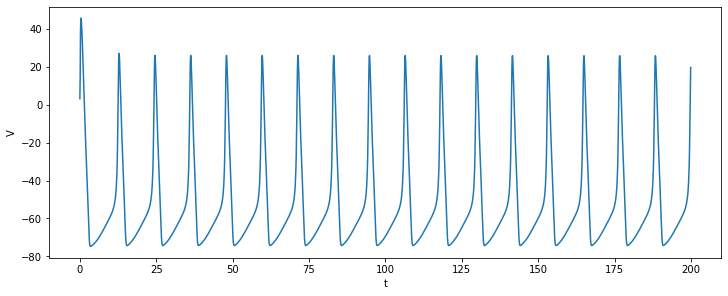

In [1]:
import brainpy as bp
from numba import prange

class HH(bp.NeuGroup):
  target_backend = 'general'

  @staticmethod
  @bp.odeint(method='exponential_euler')
  def integral(V, m, h, n, t, C, gNa, ENa, gK, EK, gL, EL, Iext):
    alpha_m = 0.1*(V+40)/(1-bp.ops.exp(-(V+40)/10))
    beta_m = 4.0*bp.ops.exp(-(V+65)/18)
    dmdt = alpha_m * (1 - m) - beta_m * m

    alpha_h = 0.07*bp.ops.exp(-(V+65)/20)
    beta_h = 1/(1+bp.ops.exp(-(V+35)/10))
    dhdt = alpha_h * (1 - h) - beta_h * h

    alpha_n = 0.01*(V+55)/(1-bp.ops.exp(-(V+55)/10))
    beta_n = 0.125*bp.ops.exp(-(V+65)/80)
    dndt = alpha_n * (1 - n) - beta_n * n

    I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
    I_K = (gK * n ** 4.0) * (V - EK)
    I_leak = gL * (V - EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / C

    return dVdt, dmdt, dhdt, dndt

  def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36.,
               EL=-54.387, gL=0.03, V_th=20., C=1.0, **kwargs):
    # parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.C = C
    self.V_th = V_th

    # variables
    num = bp.size2len(size)
    self.V = -65. * bp.ops.ones(num)
    self.m = 0.5 * bp.ops.ones(num)
    self.h = 0.6 * bp.ops.ones(num)
    self.n = 0.32 * bp.ops.ones(num)
    self.spike = bp.ops.zeros(num, dtype=bool)
    self.input = bp.ops.zeros(num)

    super(HH, self).__init__(size=size, **kwargs)

  def update(self, _t):
    V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t,
                               self.C, self.gNa, self.ENa, self.gK,
                               self.EK, self.gL, self.EL, self.input)
    self.spike = (self.V < self.V_th) * (V >= self.V_th)
    self.V = V
    self.m = m
    self.h = h
    self.n = n
    self.input[:] = 0

import brainpy as bp

dt = 0.1
bp.backend.set('numpy', dt=dt)
neu = HH(100, monitors=['V', 'spike'])
neu.t_refractory = 5.
net = bp.Network(neu)
net.run(duration=200., inputs=(neu, 'input', 21.), report=False)
fig, gs = bp.visualize.get_figure(1, 1, 4, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V", show=True)

## Reduced models
### LIF model

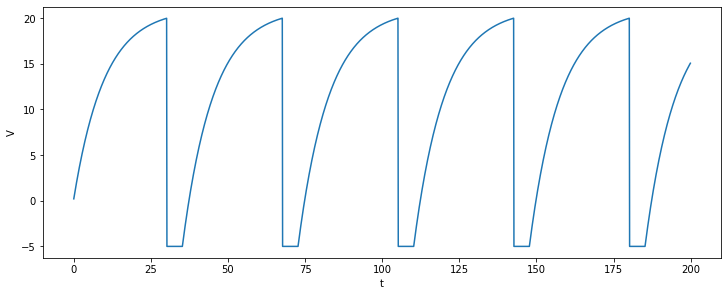

In [2]:
import brainpy as bp
from numba import prange

class LIF(bp.NeuGroup):
  target_backend = ['numpy', 'numba', 'numba-parallel', 'numba-cuda']

  @staticmethod
  def derivative(V, t, Iext, V_rest, R, tau):
    dvdt = (-V + V_rest + R * Iext) / tau
    return dvdt

  def __init__(self, size, t_refractory=1., V_rest=0.,
               V_reset=-5., V_th=20., R=1., tau=10., **kwargs):
    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.R = R
    self.tau = tau
    self.t_refractory = t_refractory

    # variables
    num = bp.size2len(size)
    self.t_last_spike = bp.ops.ones(num) * -1e7
    self.input = bp.ops.zeros(num)
    self.refractory = bp.ops.zeros(num, dtype=bool)
    self.spike = bp.ops.zeros(num, dtype=bool)
    self.V = bp.ops.ones(num) * V_rest

    self.integral = bp.odeint(self.derivative)
    super(LIF, self).__init__(size=size, **kwargs)

  def update(self, _t):
    for i in prange(self.size[0]):
      spike = 0.
      refractory = (_t - self.t_last_spike[i] <= self.t_refractory)
      if not refractory:
        V = self.integral(self.V[i], _t, self.input[i],
                          self.V_rest, self.R, self.tau)
        spike = (V >= self.V_th)
        if spike:
          V = self.V_reset
          self.t_last_spike[i] = _t
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory or spike
      self.input[i] = 0.

import brainpy as bp

dt = 0.1
bp.backend.set('numpy', dt=dt)
neu = LIF(100, monitors=['V', 'refractory', 'spike'])
neu.t_refractory = 5.
net = bp.Network(neu)
net.run(duration=200., inputs=(neu, 'input', 21.), report=False)
fig, gs = bp.visualize.get_figure(1, 1, 4, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V", show=True)

### QuaIF model

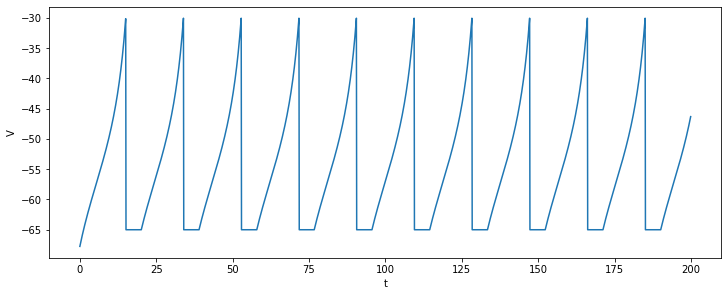

In [3]:
import brainpy as bp
from numba import prange

class QuaIF(bp.NeuGroup):
  target_backend = 'general'

  @staticmethod
  def derivative(V, t, I_ext, V_rest, V_c, R, tau, a_0):
    dVdt = (a_0 * (V - V_rest) * (V - V_c) + R * I_ext) / tau
    return dVdt

  def __init__(self, size, V_rest=-65., V_reset=-68.,
               V_th=-30., V_c=-50.0, a_0=.07,
               R=1., tau=10., t_refractory=0., **kwargs):
    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.V_c = V_c
    self.a_0 = a_0
    self.R = R
    self.tau = tau
    self.t_refractory = t_refractory

    # variables
    num = bp.size2len(size)
    self.V = bp.ops.ones(num) * V_reset
    self.input = bp.ops.zeros(num)
    self.spike = bp.ops.zeros(num, dtype=bool)
    self.refractory = bp.ops.zeros(num, dtype=bool)
    self.t_last_spike = bp.ops.ones(num) * -1e7

    self.integral = bp.odeint(f=self.derivative, method='euler')
    super(QuaIF, self).__init__(size=size, **kwargs)

  def update(self, _t):
    for i in prange(self.size[0]):
      spike = 0.
      refractory = (_t - self.t_last_spike[i] <= self.t_refractory)
      if not refractory:
        V = self.integral(self.V[i], _t, self.input[i],
                          self.V_rest, self.V_c, self.R,
                          self.tau, self.a_0)
        spike = (V >= self.V_th)
        if spike:
          V = self.V_rest
          self.t_last_spike[i] = _t
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory or spike
      self.input[i] = 0.
      
 
dt = 0.1
bp.backend.set('numpy', dt=dt)
neu = QuaIF(100, monitors=['V', 'refractory', 'spike'])
neu.t_refractory = 5.
net = bp.Network(neu)
net.run(duration=200., inputs=(neu, 'input', 21.), report=False)
fig, gs = bp.visualize.get_figure(1, 1, 4, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V", show=True)

### ExpIF model

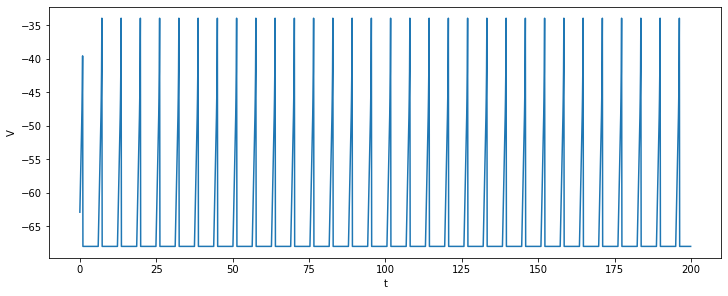

In [4]:
import brainpy as bp
from numba import prange

class ExpIF(bp.NeuGroup):
  target_backend = 'general'

  @staticmethod
  def derivative(V, t, I_ext, V_rest, delta_T, V_T, R, tau):
    exp_term = bp.ops.exp((V - V_T) / delta_T)
    dvdt = (-(V-V_rest) + delta_T*exp_term + R*I_ext) / tau
    return dvdt

  def __init__(self, size, V_rest=-65., V_reset=-68.,
               V_th=-30., V_T=-59.9, delta_T=3.48,
               R=10., C=1., tau=10., t_refractory=1.7,
               **kwargs):
    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.V_T = V_T
    self.delta_T = delta_T
    self.R = R
    self.C = C
    self.tau = tau
    self.t_refractory = t_refractory

    # variables
    self.V = bp.ops.ones(size) * V_rest
    self.input = bp.ops.zeros(size)
    self.spike = bp.ops.zeros(size, dtype=bool)
    self.refractory = bp.ops.zeros(size, dtype=bool)
    self.t_last_spike = bp.ops.ones(size) * -1e7

    self.integral = bp.odeint(self.derivative)
    super(ExpIF, self).__init__(size=size, **kwargs)

  def update(self, _t):
    for i in prange(self.num):
      spike = 0.
      refractory = (_t - self.t_last_spike[i] <= self.t_refractory)
      if not refractory:
        V = self.integral(
          self.V[i], _t, self.input[i], self.V_rest,
          self.delta_T, self.V_T, self.R, self.tau
        )
        spike = (V >= self.V_th)
        if spike:
          V = self.V_reset
          self.t_last_spike[i] = _t
        self.V[i] = V
      self.spike[i] = spike
      self.refractory[i] = refractory or spike
    self.input[:] = 0.
    
dt = 0.1
bp.backend.set('numpy', dt=dt)
neu = ExpIF(100, monitors=['V', 'refractory', 'spike'])
neu.t_refractory = 5.
net = bp.Network(neu)
net.run(duration=200., inputs=(neu, 'input', 21.), report=False)
fig, gs = bp.visualize.get_figure(1, 1, 4, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V", show=True)

### AdExIF model

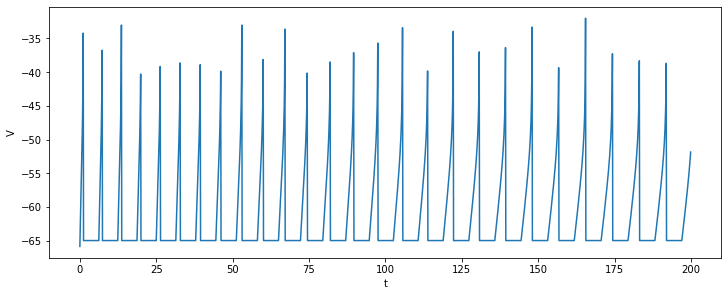

In [5]:
import brainpy as bp
from numba import prange

class AdExIF(bp.NeuGroup):
  target_backend = 'general'

  @staticmethod
  def derivative(V, w, t, I_ext, V_rest, delta_T, V_T, R, tau, tau_w, a):
    exp_term = bp.ops.exp((V-V_T)/delta_T)
    dVdt = (-(V-V_rest)+delta_T*exp_term-R*w+R*I_ext)/tau

    dwdt = (a*(V-V_rest)-w)/tau_w

    return dVdt, dwdt

  def __init__(self, size, V_rest=-65., V_reset=-68.,
               V_th=-30., V_T=-59.9, delta_T=3.48,
               a=1., b=1., R=10., tau=10., tau_w=30.,
               t_refractory=0., **kwargs):
    # parameters
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th = V_th
    self.V_T = V_T
    self.delta_T = delta_T
    self.a = a
    self.b = b
    self.R = R
    self.tau = tau
    self.tau_w = tau_w
    self.t_refractory = t_refractory

    # variables
    num = bp.size2len(size)
    self.V = bp.ops.ones(num) * V_reset
    self.w = bp.ops.zeros(size)
    self.input = bp.ops.zeros(num)
    self.spike = bp.ops.zeros(num, dtype=bool)
    self.refractory = bp.ops.zeros(num, dtype=bool)
    self.t_last_spike = bp.ops.ones(num) * -1e7

    self.integral = bp.odeint(f=self.derivative, method='euler')

    super(AdExIF, self).__init__(size=size, **kwargs)

  def update(self, _t):
    for i in prange(self.size[0]):
      spike = 0.
      refractory = (_t - self.t_last_spike[i] <= self.t_refractory)
      if not refractory:
        V, w = self.integral(self.V[i], self.w[i], _t, self.input[i],
                             self.V_rest, self.delta_T,
                             self.V_T, self.R, self.tau, self.tau_w, self.a)
        spike = (V >= self.V_th)
        if spike:
          V = self.V_rest
          w += self.b
          self.t_last_spike[i] = _t
        self.V[i] = V
        self.w[i] = w
      self.spike[i] = spike
      self.refractory[i] = refractory or spike
      self.input[i] = 0.

dt = 0.1
bp.backend.set('numpy', dt=dt)
neu = AdExIF(100, monitors=['V', 'refractory', 'spike'])
neu.t_refractory = 5.
net = bp.Network(neu)
net.run(duration=200., inputs=(neu, 'input', 21.), report=False)
fig, gs = bp.visualize.get_figure(1, 1, 4, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V", show=True)

### HindmarshRose model

parameters is set to firing mode <irregular_bursting>


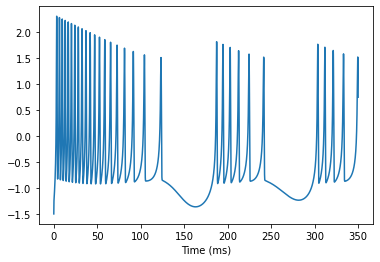

In [9]:
import brainpy as bp
from numba import prange


class HindmarshRose(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, y, z, t, a, b, I_ext, c, d, r, s, V_rest):
        dVdt = y - a * V * V * V + b * V * V - z + I_ext
        dydt = c - d * V * V - y
        dzdt = r * (s * (V - V_rest) - z)
        return dVdt, dydt, dzdt

    def __init__(self, size, a=1., b=3.,
                 c=1., d=5., r=0.01, s=4.,
                 V_rest=-1.6, **kwargs):
        # parameters
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.r = r
        self.s = s
        self.V_rest = V_rest

        # variables
        num = bp.size2len(size)
        self.z = bp.ops.zeros(num)
        self.input = bp.ops.zeros(num)
        self.V = bp.ops.ones(num) * -1.6
        self.y = bp.ops.ones(num) * -10.
        self.spike = bp.ops.zeros(num, dtype=bool)

        self.integral = bp.odeint(f=self.derivative)
        super(HindmarshRose, self).__init__(size=size, **kwargs)

    def update(self, _t):
        for i in prange(self.num):
            V, self.y[i], self.z[i] = self.integral(
                self.V[i], self.y[i], self.z[i], _t,
                self.a, self.b, self.input[i],
                self.c, self.d, self.r, self.s,
                self.V_rest)
            self.V[i] = V
            self.input[i] = 0.


bp.backend.set('numba', dt=0.02)
mode = 'irregular_bursting'
param = {'quiescence': [1.0, 2.0],  # a
         'spiking': [3.5, 5.0],  # c
         'bursting': [2.5, 3.0],  # d
         'irregular_spiking': [2.95, 3.3],  # h
         'irregular_bursting': [2.8, 3.7],  # g
         }
# set params of b and I_ext corresponding to different firing mode
print(f"parameters is set to firing mode <{mode}>")

group = HindmarshRose(size=10, b=param[mode][0],
                      monitors=['V', 'y', 'z'])

group.run(350., inputs=('input', param[mode][1]), report=False)
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)


plot nullcline ...
SymPy solve "derivative(V, y) = 0" to "y = f(V, )", success.
SymPy solve "derivative(V, y) = 0" to "y = f(V, )", success.
plot fixed point ...
SymPy solve derivative of "derivative(V, y)" by "V", success.
SymPy solve derivative of "derivative(V, y)" by "y", success.
SymPy solve derivative of "derivative(V, y)" by "V", success.
SymPy solve derivative of "derivative(V, y)" by "y", success.
Fixed point #1 at V=1.2100258869650165, y=-6.320813235627374 is a unstable focus.
plot vector field ...
plot trajectory ...


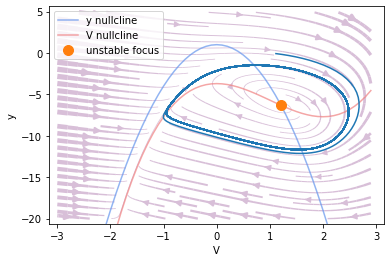

In [10]:
# Phase plane analysis
phase_plane_analyzer = bp.analysis.PhasePlane(
    group.integral,
    target_vars={'V': [-3., 3.], 'y': [-20., 5.]},
    fixed_vars={'z': 0.},
    pars_update={'I_ext': param[mode][1], 'a': 1., 'b': 3.,
                 'c': 1., 'd': 5., 'r': 0.01, 's': 4.,
                 'V_rest': -1.6}
)
phase_plane_analyzer.plot_nullcline()
phase_plane_analyzer.plot_fixed_point()
phase_plane_analyzer.plot_vector_field()
phase_plane_analyzer.plot_trajectory(
    [{'V': 1., 'y': 0., 'z': -0.}],
    duration=100.,
    show=True
)

### GeneralizedIF model

Running GIF neuron neu with mode 'tonic_spiking'
Running GIF neuron neu with mode 'class_1'
Running GIF neuron neu with mode 'spike_frequency_adaptation'
Running GIF neuron neu with mode 'phasic_spiking'


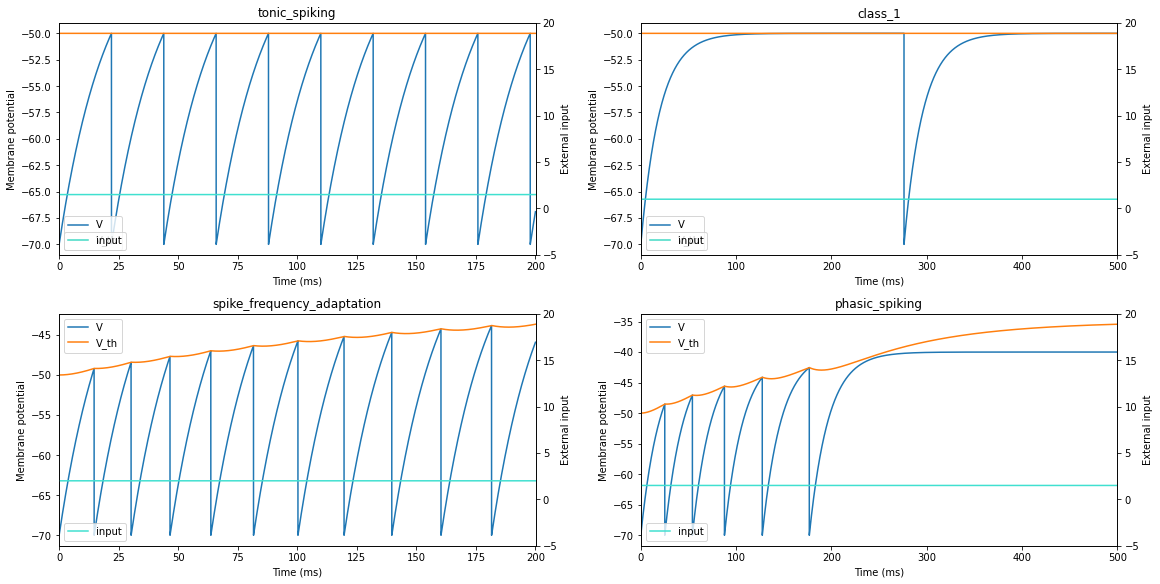

Running GIF neuron neu with mode 'accomodation'
Running GIF neuron neu with mode 'threshold_variability'
Running GIF neuron neu with mode 'rebound_spike'
Running GIF neuron neu with mode 'class_2'


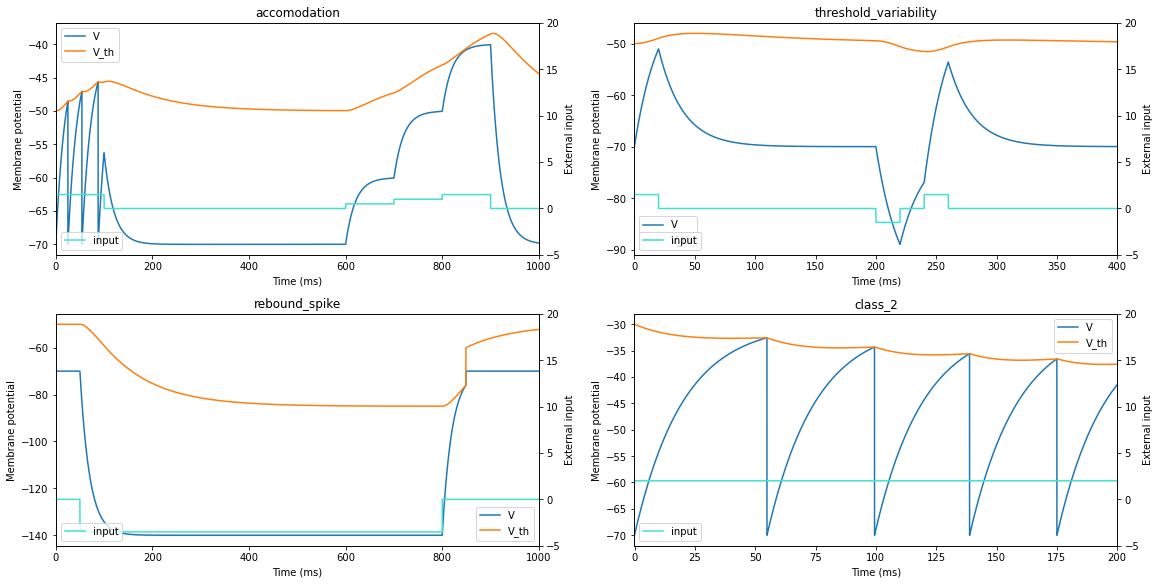

Running GIF neuron neu with mode 'integrator'
Running GIF neuron neu with mode 'input_bistability'
Running GIF neuron neu with mode 'hyperpolarization_induced_spiking'
Running GIF neuron neu with mode 'hyperpolarization_induced_bursting'


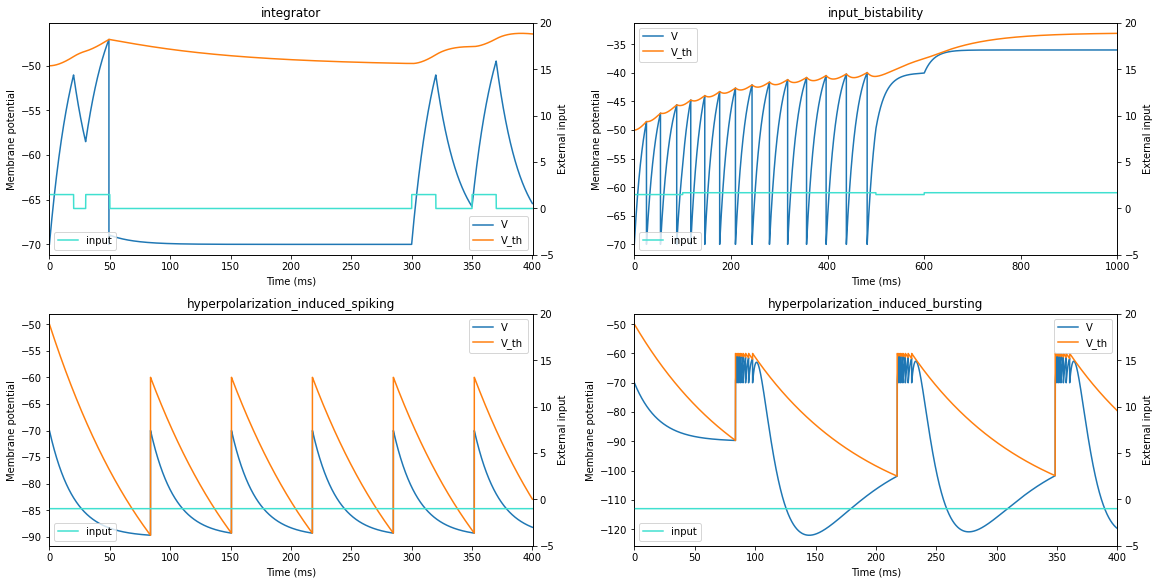

Running GIF neuron neu with mode 'tonic_bursting'
Running GIF neuron neu with mode 'phasic_bursting'
Running GIF neuron neu with mode 'rebound_burst'
Running GIF neuron neu with mode 'mixed_mode'


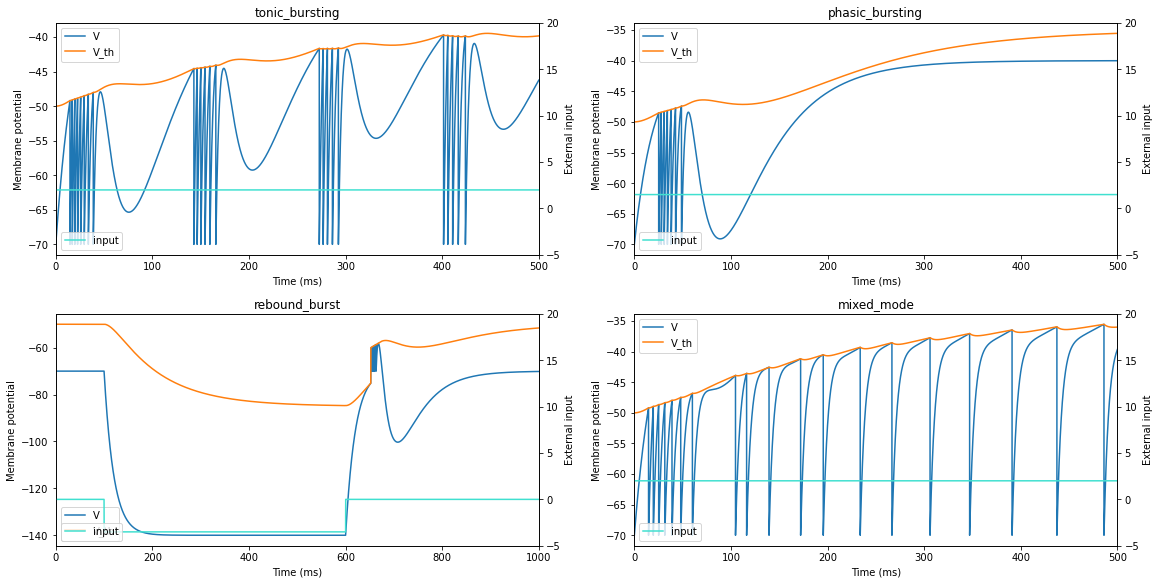

Running GIF neuron neu with mode 'afterpotentials'
Running GIF neuron neu with mode 'basal_bistability'
Running GIF neuron neu with mode 'preferred_frequency'
Running GIF neuron neu with mode 'spike_latency'


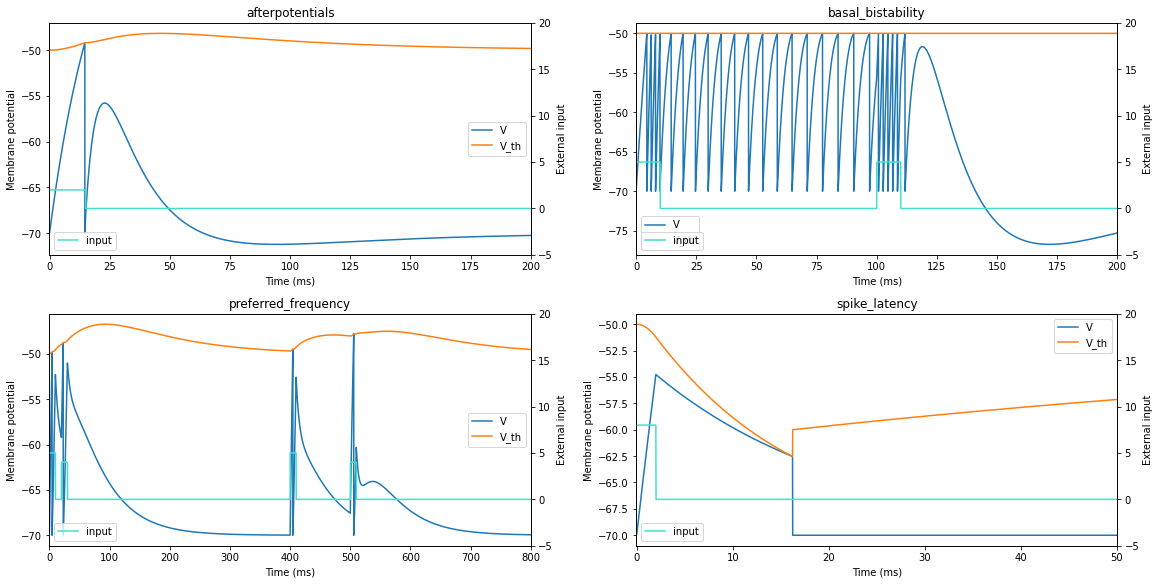

In [7]:
import brainpy as bp
from numba import prange

class GeneralizedIF(bp.NeuGroup):
  target_backend = 'general'

  @staticmethod
  def derivative(I1, I2, V_th, V, t,
                 k1, k2, a, V_rest, b, V_th_inf,
                 R, I_ext, tau):
    dI1dt = - k1 * I1
    dI2dt = - k2 * I2
    dVthdt = a * (V - V_rest) - b * (V_th - V_th_inf)
    dVdt = (- (V - V_rest) + R * I_ext + R * I1 + R * I2) / tau
    return dI1dt, dI2dt, dVthdt, dVdt

  def __init__(self, size, V_rest=-70., V_reset=-70.,
               V_th_inf=-50., V_th_reset=-60., R=20., tau=20.,
               a=0., b=0.01, k1=0.2, k2=0.02,
               R1=0., R2=1., A1=0., A2=0.,
               **kwargs):
    # params
    self.V_rest = V_rest
    self.V_reset = V_reset
    self.V_th_inf = V_th_inf
    self.V_th_reset = V_th_reset
    self.R = R
    self.tau = tau
    self.a = a
    self.b = b
    self.k1 = k1
    self.k2 = k2
    self.R1 = R1
    self.R2 = R2
    self.A1 = A1
    self.A2 = A2

    # vars
    self.input = bp.ops.zeros(size)
    self.spike = bp.ops.zeros(size, dtype=bool)
    self.I1 = bp.ops.zeros(size)
    self.I2 = bp.ops.zeros(size)
    self.V = bp.ops.ones(size) * -70.
    self.V_th = bp.ops.ones(size) * -50.

    self.integral = bp.odeint(self.derivative)
    super(GeneralizedIF, self).__init__(size=size, **kwargs)

  def update(self, _t):
    for i in prange(self.size[0]):
      I1, I2, V_th, V = self.integral(
        self.I1[i], self.I2[i], self.V_th[i], self.V[i], _t,
        self.k1, self.k2, self.a, self.V_rest,
        self.b, self.V_th_inf,
        self.R, self.input[i], self.tau
      )
      self.spike[i] = self.V_th[i] < V
      if self.spike[i]:
        V = self.V_reset
        I1 = self.R1 * I1 + self.A1
        I2 = self.R2 * I2 + self.A2
        V_th = max(V_th, self.V_th_reset)
      self.I1[i] = I1
      self.I2[i] = I2
      self.V_th[i] = V_th
      self.V[i] = V
    self.f = 0.
    self.input[:] = self.f
    
import matplotlib.pyplot as plt
import brainpy as bp
import brainmodels

# set parameters
num2mode = ["tonic_spiking", "class_1", "spike_frequency_adaptation",
            "phasic_spiking", "accomodation", "threshold_variability",
            "rebound_spike", "class_2", "integrator",
            "input_bistability", "hyperpolarization_induced_spiking", "hyperpolarization_induced_bursting",
            "tonic_bursting", "phasic_bursting", "rebound_burst",
            "mixed_mode", "afterpotentials", "basal_bistability",
            "preferred_frequency", "spike_latency"]

mode2param = {
    "tonic_spiking": {
        "input": [(1.5, 200.)]
    },
    "class_1": {
        "input": [(1. + 1e-6, 500.)]
    },
    "spike_frequency_adaptation": {
        "a": 0.005, "input": [(2., 200.)]
    },
    "phasic_spiking": {
        "a": 0.005, "input": [(1.5, 500.)]
    },
    "accomodation": {
        "a": 0.005,
        "input": [(1.5, 100.), (0, 500.), (0.5, 100.),
                  (1., 100.), (1.5, 100.), (0., 100.)]
    },
    "threshold_variability": {
        "a": 0.005,
        "input": [(1.5, 20.), (0., 180.), (-1.5, 20.),
                  (0., 20.), (1.5, 20.), (0., 140.)]
    },
    "rebound_spike": {
        "a": 0.005,
        "input": [(0, 50.), (-3.5, 750.), (0., 200.)]
    },
    "class_2": {
        "a": 0.005,
        "input": [(2 * (1. + 1e-6), 200.)],
        "V_th": -30.
    },
    "integrator": {
        "a": 0.005,
        "input": [(1.5, 20.), (0., 10.), (1.5, 20.), (0., 250.),
                  (1.5, 20.), (0., 30.), (1.5, 20.), (0., 30.)]
    },
    "input_bistability": {
        "a": 0.005,
        "input": [(1.5, 100.), (1.7, 400.),
                  (1.5, 100.), (1.7, 400.)]
    },
    "hyperpolarization_induced_spiking": {
        "V_th_reset": -60.,
        "V_th_inf": -120.,
        "input": [(-1., 400.)],
        "V_th": -50.
    },
    "hyperpolarization_induced_bursting": {
        "V_th_reset": -60.,
        "V_th_inf": -120.,
        "A1": 10.,
        "A2": -0.6,
        "input": [(-1., 400.)],
        "V_th": -50.
    },
    "tonic_bursting": {
        "a": 0.005,
        "A1": 10.,
        "A2": -0.6,
        "input": [(2., 500.)]
    },
    "phasic_bursting": {
        "a": 0.005,
        "A1": 10.,
        "A2": -0.6,
        "input": [(1.5, 500.)]
    },
    "rebound_burst": {
        "a": 0.005,
        "A1": 10.,
        "A2": -0.6,
        "input": [(0, 100.), (-3.5, 500.), (0., 400.)]
    },
    "mixed_mode": {
        "a": 0.005,
        "A1": 5.,
        "A2": -0.3,
        "input": [(2., 500.)]
    },
    "afterpotentials": {
        "a": 0.005,
        "A1": 5.,
        "A2": -0.3,
        "input": [(2., 15.), (0, 185.)]
    },
    "basal_bistability": {
        "A1": 8.,
        "A2": -0.1,
        "input": [(5., 10.), (0., 90.), (5., 10.), (0., 90.)]
    },
    "preferred_frequency": {
        "a": 0.005,
        "A1": -3.,
        "A2": 0.5,
        "input": [(5., 10.), (0., 10.), (4., 10.), (0., 370.),
                  (5., 10.), (0., 90.), (4., 10.), (0., 290.)]
    },
    "spike_latency": {
        "a": -0.08,
        "input": [(8., 2.), (0, 48.)]
    }
}


def run_GIF_with_mode(mode='tonic_spiking', size=10.,
                      row_p=0, col_p=0, fig=None, gs=None):
    print(f"Running GIF neuron neu with mode '{mode}'")
    neu = brainmodels.neurons.GeneralizedIF(size, monitors=['V', 'V_th', 'I1', 'I2', 'input'])
    param = mode2param[mode].items()
    member_type = 0
    for (k, v) in param:
        if k == 'input':
            I_ext, dur = bp.inputs.constant_current(v)
            member_type += 1
        else:
            if member_type == 0:
                exec("neu.%s = %f" % (k, v))
            else:
                exec("neu.%s = bp.ops.ones(size) * %f" % (k, v))
    neu.run(dur, inputs=('input', I_ext), report=False)

    ts = neu.mon.ts
    ax1 = fig.add_subplot(gs[row_p, col_p])
    ax1.title.set_text(f'{mode}')

    ax1.plot(ts, neu.mon.V[:, 0], label='V')
    ax1.plot(ts, neu.mon.V_th[:, 0], label='V_th')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Membrane potential')
    ax1.set_xlim(-0.1, ts[-1] + 0.1)
    plt.legend()

    ax2 = ax1.twinx()
    ax2.plot(ts, I_ext, color='turquoise', label='input')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('External input')
    ax2.set_xlim(-0.1, ts[-1] + 0.1)
    ax2.set_ylim(-5., 20.)
    plt.legend(loc='lower left')


size = 10
pattern_num = 20
row_b = 2
col_b = 2
size_b = row_b * col_b
for i in range(pattern_num):
    if i % size_b == 0:
        fig, gs = bp.visualize.get_figure(row_b, col_b, 4, 8)
    mode = num2mode[i]
    run_GIF_with_mode(mode=mode, size=size,
                      row_p=i % size_b // col_b,
                      col_p=i % size_b % col_b,
                      fig=fig, gs=gs)
    if (i + 1) % size_b == 0:
        plt.show()

## Firing rate models
### Firing rate unit

In [8]:
import brainpy as bp
from numba import prange

class FiringRateUnit(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(a_e, a_i, t,
                   k_e, r_e, c1, c2, I_ext_e, slope_e, theta_e, tau_e,
                   k_i, r_i, c3, c4, I_ext_i, slope_i, theta_i, tau_i):
        x_ae = c1 * a_e - c2 * a_i + I_ext_e
        sigmoid_ae_l = 1 / (1 + bp.ops.exp(- slope_e * (x_ae - theta_e)))
        sigmoid_ae_r = 1 / (1 + bp.ops.exp(slope_e * theta_e))
        sigmoid_ae = sigmoid_ae_l - sigmoid_ae_r
        daedt = (- a_e + (k_e - r_e * a_e) * sigmoid_ae) / tau_e

        x_ai = c3 * a_e - c4 * a_i + I_ext_i
        sigmoid_ai_l = 1 / (1 + bp.ops.exp(- slope_i * (x_ai - theta_i)))
        sigmoid_ai_r = 1 / (1 + bp.ops.exp(slope_i * theta_i))
        sigmoid_ai = sigmoid_ai_l - sigmoid_ai_r
        daidt = (- a_i + (k_i - r_i * a_i) * sigmoid_ai) / tau_i
        return daedt, daidt

    def __init__(self, size, c1=12., c2=4., c3=13., c4=11.,
                 k_e=1., k_i=1., tau_e=1., tau_i=1., r_e=1., r_i=1.,
                 slope_e=1.2, slope_i=1., theta_e=2.8, theta_i=4.,
                 **kwargs):
        # params
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.c4 = c4
        self.k_e = k_e
        self.k_i = k_i
        self.tau_e = tau_e
        self.tau_i = tau_i
        self.r_e = r_e
        self.r_i = r_i
        self.slope_e = slope_e
        self.slope_i = slope_i
        self.theta_e = theta_e
        self.theta_i = theta_i

        # vars
        self.input_e = bp.backend.zeros(size)
        self.input_i = bp.backend.zeros(size)
        self.a_e = bp.backend.ones(size) * 0.1
        self.a_i = bp.backend.ones(size) * 0.05

        self.integral = bp.odeint(self.derivative)
        super(FiringRateUnit, self).__init__(size=size, **kwargs)

    def update(self, _t):
        self.a_e, self.a_i = self.integral(
            self.a_e, self.a_i, _t,
            self.k_e, self.r_e, self.c1, self.c2,
            self.input_e, self.slope_e,
            self.theta_e, self.tau_e,
            self.k_i, self.r_i, self.c3, self.c4,
            self.input_i, self.slope_i,
            self.theta_i, self.tau_i)
        self.input_e[:] = 0.
        self.input_i[:] = 0.